# CBOW

- import libraries

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
# Define the corpus
corpus = ['The cat sat on the mat',
          'The dog ran in the park',
          'The bird sang in the tree']


In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

print("Sequences of words in the corpus:", sequences)


Sequences of words in the corpus: [[1, 3, 4, 5, 1, 6], [1, 7, 8, 2, 1, 9], [1, 10, 11, 2, 1, 12]]


In [24]:
# Parameters
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_size = 10  # Size of the word embeddings
window_size = 1  # Context window size

In [25]:
# Generate context-target pairs
contexts = [] # context words
targets = [] # center word

for sequence in sequences:
    for i in range(window_size, len(sequence) - window_size):
        context = sequence[i-window_size:i] + sequence[i+1:i+window_size+1]
        target = sequence[i]
        contexts.append(context)
        targets.append(target)

print(contexts, '\n', targets)

[[1, 4], [3, 5], [4, 1], [5, 6], [1, 8], [7, 2], [8, 1], [2, 9], [1, 11], [10, 2], [11, 1], [2, 12]] 
 [3, 4, 5, 1, 7, 8, 2, 1, 10, 11, 2, 1]


In [26]:
# Create Dataset and DataLoader
class CBOWDataset(Dataset):
    def __init__(self, contexts, targets):
        self.contexts = torch.tensor(contexts, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.contexts[idx], self.targets[idx]
    
dataset = CBOWDataset(contexts, targets)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [27]:
# Define CBOW model in PyTorch
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        embedded = self.embeddings(inputs)  # Get embeddings for the context words
        # Take the average of the context word embeddings
        embedded_mean = embedded.mean(dim=1)
        out = self.linear(embedded_mean)  # Feed to linear layer to get word probabilities
        return out
    
    def get_weights(self):
        """Get model weights as tensors"""
        return [self.embeddings.weight.data]#, self.linear.weight.data, self.linear.bias.data]

In [28]:
# Initialize the model, loss function, and optimizer
model = CBOWModel(vocab_size=vocab_size, embedding_size=embedding_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [29]:
# Training loop
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for context, target in dataloader:
        optimizer.zero_grad()
        output = model(context)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss/len(dataloader)}')

Epoch 0, Loss: 2.575410763422648
Epoch 10, Loss: 1.262436290582021
Epoch 20, Loss: 0.6937621136506399
Epoch 30, Loss: 0.48603611439466476
Epoch 40, Loss: 0.4274365020294984
Epoch 50, Loss: 0.4127255119383335
Epoch 60, Loss: 0.39396259002387524
Epoch 70, Loss: 0.38018758098284405
Epoch 80, Loss: 0.38295874232426286
Epoch 90, Loss: 0.37228934932500124


In [35]:
print(model.get_weights()[0].shape, '\n', model.get_weights()[0])  

torch.Size([13, 10]) 
 tensor([[ 0.7374, -0.3716,  0.8979, -0.4254,  0.3047,  0.6900, -0.1329, -1.0195,
         -0.4236, -0.9277],
        [-0.7763,  2.5665, -0.2802, -0.6883,  0.6247,  1.4601, -0.3857,  0.4477,
         -1.6629, -0.4785],
        [-1.8174, -2.1687,  0.0359, -1.6331, -1.7624,  0.5142,  0.1069,  0.5297,
          1.5707,  0.7969],
        [ 1.8309, -3.0454,  0.3255,  1.1568, -0.8623,  1.9370,  3.0266,  0.3762,
          0.5319, -1.7579],
        [ 0.2370,  1.9585, -1.6448,  1.0221,  1.8336,  0.1951,  1.5079,  1.3291,
          0.8192, -2.5984],
        [-0.7512, -1.0665,  1.3403, -0.6524, -0.9383,  0.7350,  2.0867, -3.1489,
          1.9744, -0.7293],
        [-2.7963, -0.4078, -0.9358, -1.2386, -0.7744,  2.7861,  0.7542, -0.0577,
          1.1260,  1.2153],
        [ 1.6155, -1.7798,  1.9688, -0.1993, -0.7554,  2.9077, -1.4282,  1.1367,
          0.2061, -0.7471],
        [-0.8398, -0.2886,  2.7281,  2.8397,  1.5317,  1.0738, -1.4453, -1.0673,
         -2.1801,  1.657

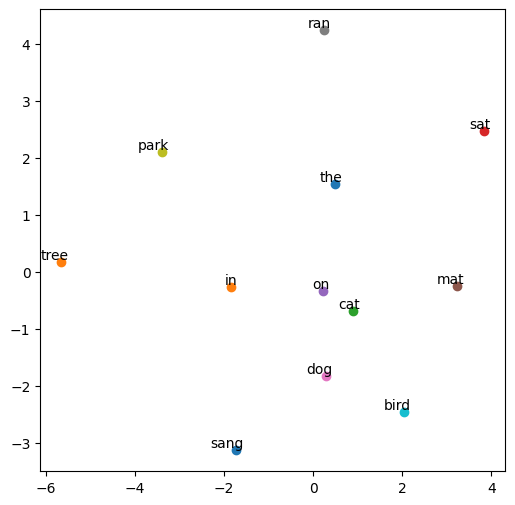

In [30]:
# Get the word embeddings from the trained CBOW model
embeddings = model.get_weights()[0]

# Use PCA to reduce dimensionality
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the word embeddings
plt.figure(figsize=(6,6))
for i, word in enumerate(tokenizer.word_index.keys()):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(5,2), 
                                                              ha='right')
plt.show()